PER and DARKO DPM ratings were sourced from [basketball-reference.com](https://www.basketball-reference.com/leagues/NBA_2025_advanced.html) as well as Kostya Medvedovsky's [DARKO website](https://apanalytics.shinyapps.io/DARKO/). Clicking on the links will directly show you the dataset you need to export, but unfortunately for the latter the data is no longer available due to their database being continuously updated.

I have included in the repository a copy of the DARKO dataset updated up until the end of the 2024-2025 NBA regular season, dated April 29, 2025. But if you wish to skip the data gathering from both sides, I also included a dataset that combines both ratings for players with filename: ***'PER_DARKO_combined_dataset.xlsx'***.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(0, str(Path.cwd().resolve().parent))  # add repo root to sys.path

from project_paths import (
    RAW_DIR, EDITED_DIR, FINAL_DIR, ANALYSIS_DIR, TEMP_DIR, DATA_DIR, ROOKIES_PATH
)

from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

# Load input
BASE_DIR = DATA_DIR
ANALYSIS_DIR = ANALYSIS_DIR
INPUT_PATH   = ANALYSIS_DIR / "PER_DARKO_combined_dataset.xlsx"
OUTPUT_PATH  = ANALYSIS_DIR / "PER_DARKO_classified.xlsx"

if not INPUT_PATH.exists():
    raise FileNotFoundError(f"Could not find: {INPUT_PATH}")
df_pd = pd.read_excel(INPUT_PATH)

required_cols = {"Player", "PER", "DPM"}
missing = required_cols - set(df_pd.columns)
if missing:
    raise KeyError(f"Missing required columns: {sorted(missing)}")

df_pd['Player'] = df_pd['Player'].astype(str).str.strip()
df_pd['PER'] = pd.to_numeric(df_pd['PER'], errors='coerce')
df_pd['DPM'] = pd.to_numeric(df_pd['DPM'], errors='coerce')

[John Hollinger](https://www.espn.com/nba/hollinger/statistics/_/year/2025) himself stated that the league average in computing for the PER every season is always set to 15.00, so we inferred that role players can be rated at maximum with this as well. As a last resort, [this wikipedia article about PER](https://en.wikipedia.org/wiki/Player_efficiency_rating#Reference_guide) also provides a reference guide on how PER describes a player's performance in the season that PER was computed for.

As for DARKO DPM, since the ranges rarely goes above double-digits both ways, we setup the cutoffs for role players to be as high as '0', meaning that they don't necessarily [impact the score of a game](https://apanalytics.shinyapps.io/DARKO/), while a baseline of above '-1' so that negatively impacting a game by their presence should start from a round number of exactly '-1'.

In [2]:
# Cutoffs for classifications
def classify_per(x: float) -> str:
    if pd.isna(x): return "UNKNOWN"
    return "STARTER" if x >= 15 else ("ROLEPLAYER" if x >= 13 else "BENCHWARMER")

def classify_dpm(x: float) -> str:
    if pd.isna(x): return "UNKNOWN"
    return "STARTER" if x >= 0 else ("ROLEPLAYER" if x >= -1 else "BENCHWARMER")

df_pd['PER Classification'] = df_pd['PER'].apply(classify_per)
df_pd['DPM Classification'] = df_pd['DPM'].apply(classify_dpm)

# Preview + counts
display(df_pd[['Player', 'PER', 'DPM', 'PER Classification', 'DPM Classification']].head(10))
print("\nPER Classification counts:\n", df_pd['PER Classification'].value_counts(dropna=False))
print("\nDPM Classification counts:\n", df_pd['DPM Classification'].value_counts(dropna=False))

,Player,PER,DPM,PER Classification,DPM Classification
0,"ACHIUWA, Precious",13.6,-1.58,ROLEPLAYER,BENCHWARMER
1,"ADAMS, Steven",16.6,1.87,STARTER,STARTER
2,"ADEBAYO, Bam",18.9,1.18,STARTER,STARTER
3,"AGBAJI, Ochai",12.0,-1.94,BENCHWARMER,BENCHWARMER
4,"ALDAMA, Santi",16.8,0.42,STARTER,STARTER
5,"ALEXANDER-WALKER, Nickeil",11.6,0.28,BENCHWARMER,STARTER
6,"ALLEN, Grayson",13.7,0.70,ROLEPLAYER,STARTER
7,"ALLEN, Jarrett",22.1,2.76,STARTER,STARTER
8,"ALVARADO, Jose",13.4,0.63,ROLEPLAYER,STARTER
9,"ANDERSON, Kyle",15.1,-1.39,STARTER,BENCHWARMER



PER Classification counts:
 PER Classification
BENCHWARMER    234
STARTER        192
ROLEPLAYER      71
Name: count, dtype: int64

DPM Classification counts:
 DPM Classification
BENCHWARMER    215
STARTER        174
ROLEPLAYER     108
Name: count, dtype: int64


In [3]:
ml_candidates = [
    ANALYSIS_DIR / "ML_Classification_Analysis_dataset.xlsx",
    ANALYSIS_DIR / "ML_Classification_analysis_dataset.xlsx",
]
ml_path = next((p for p in ml_candidates if p.exists()), None)
if ml_path is None:
    raise FileNotFoundError(
        f"Could not find ML results. Looked for:\n- {ml_candidates[0]}\n- {ml_candidates[1]}"
    )

combined_out = ANALYSIS_DIR / "Classification_Models_Analysis.xlsx"

# Load ML results
ml_df = pd.read_excel(ml_path)

# Normalize player names on both sides
ml_df['Player'] = ml_df['Player'].astype(str).str.strip()
df_pd['Player'] = df_pd['Player'].astype(str).str.strip()

# Columns to append from the PER/DPM file
per_dpm_cols = ['Player', 'PER Classification', 'DPM Classification']
missing_cols = [c for c in per_dpm_cols if c not in df_pd.columns]
if missing_cols:
    raise KeyError(f"Missing columns in PER/DPM frame: {missing_cols}")

# Inner-join on Player (drop anyone not present in both datasets)
out_df = ml_df.merge(df_pd[per_dpm_cols], on='Player', how='inner')

# Save
out_df.to_excel(combined_out, index=False)
print(f"Combined analysis saved to: {combined_out}")

# Quick peek
display(out_df.head(10))

Combined analysis saved to: C:\Users\jhbagamasbad\Documents\rs-classification\data\ANALYSIS\Classification_Models_Analysis.xlsx


,Player,True Label,KNN Prediction,Decision Tree Prediction,Naive Bayes Prediction,PER Classification,DPM Classification
0,"ACHIUWA, Precious",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER
1,"ADEBAYO, Bam",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER
2,"AGBAJI, Ochai",STARTER,BENCHWARMER,ROLEPLAYER,BENCHWARMER,BENCHWARMER,BENCHWARMER
3,"ALDAMA, Santi",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,STARTER
4,"ALEXANDER-WALKER, Nickeil",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER,STARTER
5,"ALLEN, Grayson",STARTER,STARTER,STARTER,STARTER,ROLEPLAYER,STARTER
6,"ALLEN, Jarrett",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER
7,"ALVARADO, Jose",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER
8,"ANDERSON, Kyle",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,BENCHWARMER
9,"ANTETOKOUNMPO, Giannis",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER


In [4]:
# Append RANK SCORE (float) + classification; keep only intersecting players; put RANK_SCORE last

rank_path = ANALYSIS_DIR / "RANK_SCORE_analysis_dataset.xlsx"
if not rank_path.exists():
    raise FileNotFoundError(f"Could not find: {rank_path}")

# Load dataset
rank_df = pd.read_excel(rank_path)
rank_required = {"Player", "RANK_SCORE", "Classification"}
missing_rank = rank_required - set(rank_df.columns)
if missing_rank:
    raise KeyError(f"Missing required columns in RANK SCORE file: {sorted(missing_rank)}")

# Normalize + cast types
rank_df["Player"] = rank_df["Player"].astype(str).str.strip()
rank_df["RANK_SCORE"] = pd.to_numeric(rank_df["RANK_SCORE"], errors="coerce")

# If duplicates per player exist, keep the row with the highest RANK_SCORE
rank_df = (
    rank_df.sort_values("RANK_SCORE", ascending=False)
           .drop_duplicates(subset="Player", keep="first")
           .rename(columns={"Classification": "RANK SCORE Classification"})
           [["Player", "RANK_SCORE", "RANK SCORE Classification"]]
)

# Ensure 'out_df' exists (ML + PER/DPM). If not, load the saved combined file.
combined_out = ANALYSIS_DIR / "Classification_Models_Analysis.xlsx"
if "out_df" not in globals():
    if not combined_out.exists():
        raise RuntimeError("Expected 'out_df' from the previous merge step; saved file not found. "
                           "Please run the prior merge first.")
    out_df = pd.read_excel(combined_out)
    out_df["Player"] = out_df["Player"].astype(str).str.strip()

# Inner join to keep only players present in both (drops players missing from either file)
final_combined = out_df.merge(rank_df, on="Player", how="inner")

# Move RANK_SCORE to the rightmost column
cols = [c for c in final_combined.columns if c != "RANK_SCORE"] + ["RANK_SCORE"]
final_combined = final_combined[cols]

# Save (overwrite)
final_combined.to_excel(combined_out, index=False)
print(f"Updated combined analysis (with RANK SCORE) saved to: {combined_out}")

# Quick peek
from IPython.display import display
display(final_combined.head(10))

Updated combined analysis (with RANK SCORE) saved to: C:\Users\jhbagamasbad\Documents\rs-classification\data\ANALYSIS\Classification_Models_Analysis.xlsx


,Player,True Label,KNN Prediction,Decision Tree Prediction,Naive Bayes Prediction,PER Classification,DPM Classification,RANK SCORE Classification,RANK_SCORE
0,"ACHIUWA, Precious",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER,BENCHWARMER,3.000
1,"ADEBAYO, Bam",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,7.067
2,"AGBAJI, Ochai",STARTER,BENCHWARMER,ROLEPLAYER,BENCHWARMER,BENCHWARMER,BENCHWARMER,BENCHWARMER,3.333
3,"ALDAMA, Santi",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,STARTER,BENCHWARMER,2.400
4,"ALEXANDER-WALKER, Nickeil",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER,STARTER,BENCHWARMER,3.200
5,"ALLEN, Grayson",STARTER,STARTER,STARTER,STARTER,ROLEPLAYER,STARTER,STARTER,6.200
6,"ALLEN, Jarrett",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,5.200
7,"ALVARADO, Jose",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,BENCHWARMER,1.300
8,"ANDERSON, Kyle",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,BENCHWARMER,BENCHWARMER,3.133
9,"ANTETOKOUNMPO, Giannis",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,7.667


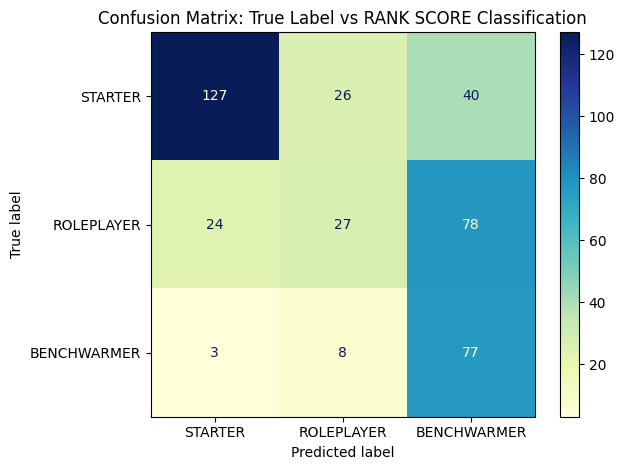

In [5]:
# Confusion matrix: True Label vs RANK SCORE Classification
# Clean + restrict to valid labels
label_order = ["STARTER", "ROLEPLAYER", "BENCHWARMER"]
df_cm = final_combined.copy()
df_cm["True Label"] = df_cm["True Label"].astype(str).str.strip()
df_cm["RANK SCORE Classification"] = df_cm["RANK SCORE Classification"].astype(str).str.strip()

mask_valid = df_cm["True Label"].isin(label_order) & df_cm["RANK SCORE Classification"].isin(label_order)
df_cm = df_cm.loc[mask_valid, ["True Label", "RANK SCORE Classification"]]

# Confusion matrix (counts) with requested order
cm = confusion_matrix(
    df_cm["True Label"],
    df_cm["RANK SCORE Classification"],
    labels=label_order
)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='YlGnBu')
ax.set_title("Confusion Matrix: True Label vs RANK SCORE Classification")
plt.tight_layout()
plt.show()

In [6]:
# Work copy for evaluating thresholds
dfw = final_combined.copy()
dfw["True Label"] = dfw["True Label"].astype(str).str.strip()
label_order = ["STARTER", "ROLEPLAYER", "BENCHWARMER"]
dfw = dfw[dfw["True Label"].isin(label_order)].copy()
dfw = dfw[~dfw["RANK_SCORE"].isna()].copy()

# Define ROLEPLAYER range
def classify_from_band(score, low, high):
    # roleplayer band is [low, high)
    if score >= high:
        return "STARTER"
    elif score < low:
        return "BENCHWARMER"
    else:
        return "ROLEPLAYER"

def apply_band(scores: pd.Series, low: float, high: float) -> pd.Series:
    return scores.apply(lambda s: classify_from_band(s, low, high))

In [7]:
# ROLEPLAYER range search
# Original range: [4, 5)
# Allowed adjustments: low >= 3, high < 6, with low < high.
s_min, s_max = dfw["RANK_SCORE"].min(), dfw["RANK_SCORE"].max()
pad = max(0.25, 0.02 * (s_max - s_min))

low_grid  = np.round(np.arange(max(3.0, s_min - pad), min(5.95, s_max + pad), 0.1), 3)
high_grid = np.round(np.arange(max(4.05, s_min + 0.05), min(6.0,  s_max + pad), 0.1), 3)  # < 6.0

# Fallbacks if empty
if low_grid.size == 0:
    low_grid = np.array([4.0])
if high_grid.size == 0:
    high_grid = np.array([5.0])

y_true = dfw["True Label"].values

# Get max overall Accuracy
best_acc = -1.0
best_acc_pair = (4.0, 5.0)
best_acc_pred = None

# Get max F1 for ROLEPLAYER
best_f1  = -1.0
best_f1_pair = (4.0, 5.0)
best_f1_pred = None

for low in low_grid:
    for high in high_grid:
        if not (low < high):
            continue
        # Enforce constraints explicitly
        if low < 3.0 or high >= 6.0:
            continue

        y_pred = apply_band(dfw["RANK_SCORE"], low, high).values

        # Accuracy
        acc = (y_pred == y_true).mean()

        # F1 for ROLEPLAYER (one-vs-rest)
        y_true_bin = (y_true == "ROLEPLAYER").astype(int)
        y_pred_bin = (y_pred == "ROLEPLAYER").astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

        if acc > best_acc:
            best_acc, best_acc_pair, best_acc_pred = acc, (low, high), y_pred

        if f1 > best_f1:
            best_f1, best_f1_pair, best_f1_pred = f1, (low, high), y_pred

print(f"Best Accuracy: {best_acc:.4f} @ ROLEPLAYER band [low, high) = {best_acc_pair}")
print(f"Best ROLEPLAYER F1: {best_f1:.4f} @ ROLEPLAYER band [low, high) = {best_f1_pair}")

Best Accuracy: 0.6024 @ ROLEPLAYER band [low, high) = (np.float64(3.0), np.float64(4.85))
Best ROLEPLAYER F1: 0.5143 @ ROLEPLAYER band [low, high) = (np.float64(3.0), np.float64(5.65))


In [8]:

# Add adjusted classifications to the dataset
def classify_series(scores: pd.Series, pair):
    low, high = pair
    return scores.apply(lambda s: classify_from_band(s, low, high) if pd.notna(s) else np.nan)

final_combined["RS Classification (ACC Adj)"]     = classify_series(final_combined["RANK_SCORE"], best_acc_pair)
final_combined["RS Classification (F-SCORE Adj)"] = classify_series(final_combined["RANK_SCORE"], best_f1_pair)

# Drop RANK_SCORE
final_combined = final_combined.drop(columns=["RANK_SCORE"], errors="ignore")

# Save back to dataset
final_combined.to_excel(combined_out, index=False)
print(f"\nAdded adjusted classification columns, dropped 'RANK_SCORE', and saved to: {combined_out}")


Added adjusted classification columns, dropped 'RANK_SCORE', and saved to: C:\Users\jhbagamasbad\Documents\rs-classification\data\ANALYSIS\Classification_Models_Analysis.xlsx


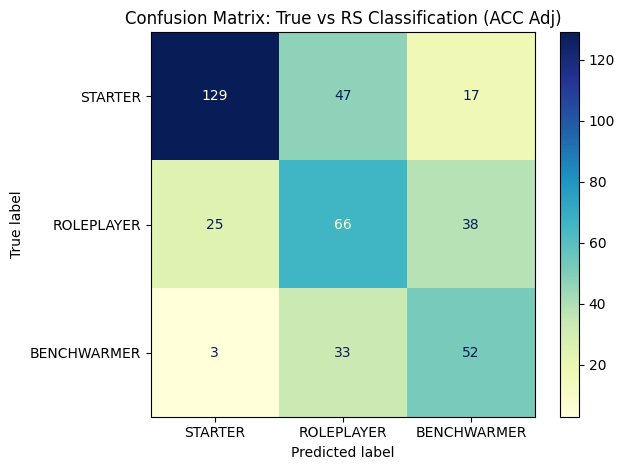

In [9]:
# --- Confusion matrices (ordered: STARTER, ROLEPLAYER, BENCHWARMER) ---
def show_confusion(df, pred_col, title_suffix):
    sub = df.copy()
    sub = sub[sub["True Label"].isin(label_order)]
    sub = sub[sub[pred_col].isin(label_order)]
    y_t = sub["True Label"].values
    y_p = sub[pred_col].values

    cm = confusion_matrix(y_t, y_p, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap='YlGnBu')
    ax.set_title(f"Confusion Matrix: True vs {title_suffix}")
    plt.tight_layout()
    plt.show()

show_confusion(final_combined, "RS Classification (ACC Adj)", "RS Classification (ACC Adj)")

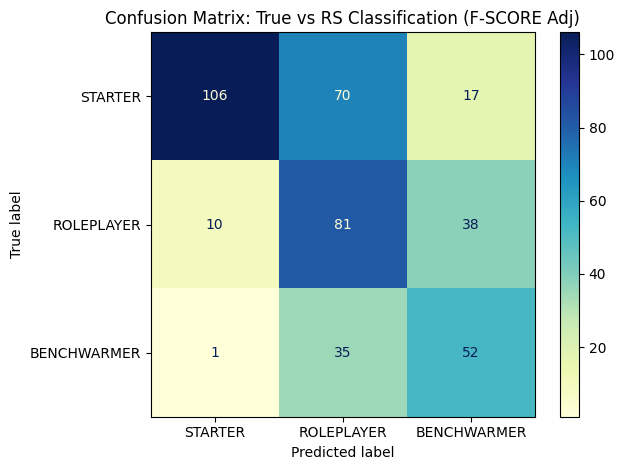

In [10]:
show_confusion(final_combined, "RS Classification (F-SCORE Adj)", "RS Classification (F-SCORE Adj)")

In [11]:
display(final_combined.head(10))

,Player,True Label,KNN Prediction,Decision Tree Prediction,Naive Bayes Prediction,PER Classification,DPM Classification,RANK SCORE Classification,RS Classification (ACC Adj),RS Classification (F-SCORE Adj)
0,"ACHIUWA, Precious",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER,BENCHWARMER,ROLEPLAYER,ROLEPLAYER
1,"ADEBAYO, Bam",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER
2,"AGBAJI, Ochai",STARTER,BENCHWARMER,ROLEPLAYER,BENCHWARMER,BENCHWARMER,BENCHWARMER,BENCHWARMER,ROLEPLAYER,ROLEPLAYER
3,"ALDAMA, Santi",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,STARTER,BENCHWARMER,BENCHWARMER,BENCHWARMER
4,"ALEXANDER-WALKER, Nickeil",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,BENCHWARMER,STARTER,BENCHWARMER,ROLEPLAYER,ROLEPLAYER
5,"ALLEN, Grayson",STARTER,STARTER,STARTER,STARTER,ROLEPLAYER,STARTER,STARTER,STARTER,STARTER
6,"ALLEN, Jarrett",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,ROLEPLAYER
7,"ALVARADO, Jose",STARTER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,BENCHWARMER,BENCHWARMER,BENCHWARMER
8,"ANDERSON, Kyle",ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,ROLEPLAYER,STARTER,BENCHWARMER,BENCHWARMER,ROLEPLAYER,ROLEPLAYER
9,"ANTETOKOUNMPO, Giannis",STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER,STARTER


In [12]:
df = final_combined.copy()

columns_to_compare = [
    "True Label",
    "KNN Prediction",
    "Decision Tree Prediction",
    "Naive Bayes Prediction",
    "RS Classification (ACC Adj)",
    "RS Classification (F-SCORE Adj)",
    "RANK SCORE Classification",
    "DPM Classification",
    "PER Classification",
]

# Keep only columns that actually exist
available_cols = [c for c in columns_to_compare if c in df.columns]
missing_cols   = [c for c in columns_to_compare if c not in df.columns]
if missing_cols:
    print("Note: missing from dataset and skipped ->", missing_cols)

In [13]:
# --- Build agreement matrix (pairwise % agreement, ignoring rows with NaNs in either column) ---
agreement_matrix = pd.DataFrame(index=available_cols, columns=available_cols, dtype=float)

for col1 in available_cols:
    for col2 in available_cols:
        mask = df[col1].notna() & df[col2].notna()
        denom = mask.sum()
        if denom == 0:
            agreement_matrix.loc[col1, col2] = np.nan
        else:
            matches = (df.loc[mask, col1] == df.loc[mask, col2]).sum()
            agreement_matrix.loc[col1, col2] = 100.0 * matches / denom

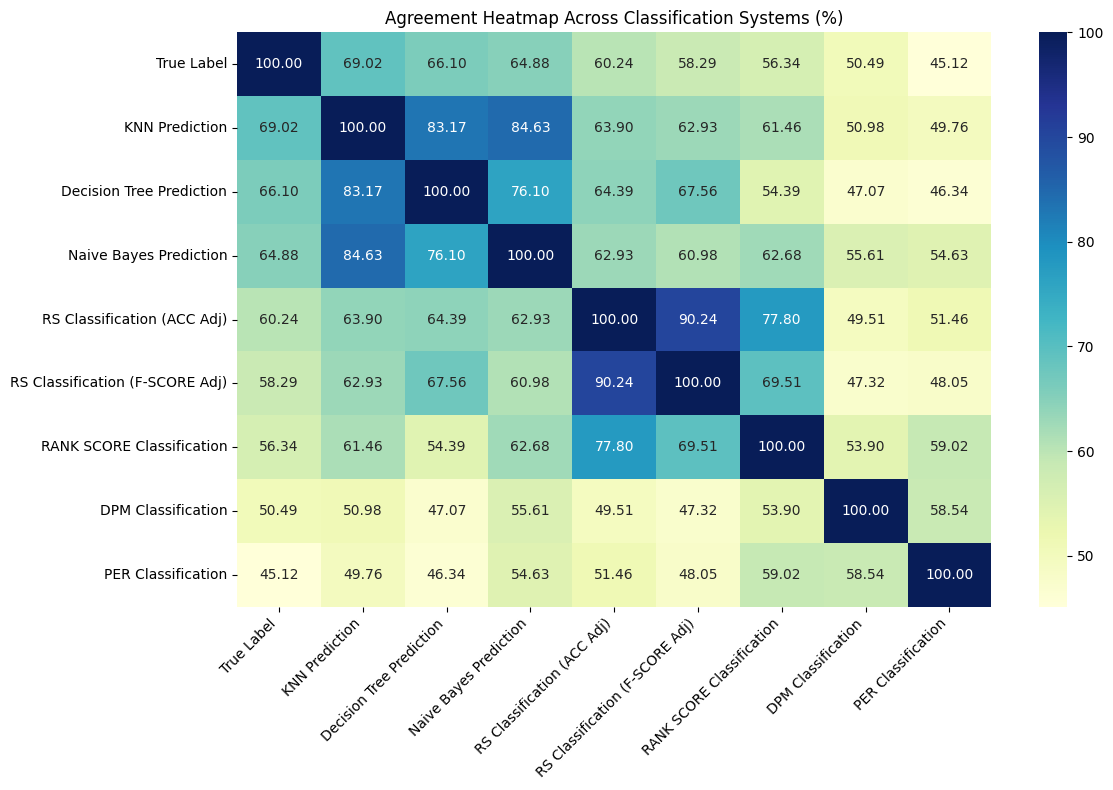

In [14]:
# --- Show heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(agreement_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Agreement Heatmap Across Classification Systems (%)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()